In [1]:
!pip install -U fastai

     |████████████████████████████████| 194kB 12.7MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision.all import *
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
print(os.listdir("/content/drive/My Drive/"))

['Colab Notebooks', 'AlzheimersDataset', 'skin_cancer', 'Kaggle_Skin_Cancer', 'Dataset']


In [5]:
path = Path("/content/drive/My Drive/Dataset/")
model_path = Path(path/'models')
train_path = Path(path/'train')
path.ls()

(#29) [Path('/content/drive/My Drive/Dataset/test'),Path('/content/drive/My Drive/Dataset/valid'),Path('/content/drive/My Drive/Dataset/train'),Path('/content/drive/My Drive/Dataset/models'),Path('/content/drive/My Drive/Dataset/test_result_resnet50.csv'),Path('/content/drive/My Drive/Dataset/val_result_resnet50.csv'),Path('/content/drive/My Drive/Dataset/SkinCancer_Effnet.ipynb'),Path('/content/drive/My Drive/Dataset/val_result_effnetB0.csv'),Path('/content/drive/My Drive/Dataset/test_result_effnetB0.csv'),Path('/content/drive/My Drive/Dataset/deployment')...]

# Data Loading

In [6]:
def get_data(img_size, bs):
  item_tfms = RandomResizedCrop(480, min_scale=0.80)
  batch_tfms = [*aug_transforms(size=img_size, max_rotate=20, flip_vert=True), Normalize()]

  data = ImageDataLoaders.from_folder(path, train='train', valid='valid', 
                                      bs=bs, item_tfms=item_tfms, batch_tfms=batch_tfms)
  return data

In [ ]:
bs = 32
img_size = 128
data = get_data(img_size, bs)

# VGG16

## Training on low-resolution images

In [ ]:
vgg16_model = cnn_learner(data, vgg16_bn, opt_func=ranger, metrics=accuracy, model_dir=model_path, cbs=[ShowGraphCallback]).to_fp16()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
vgg16_model.summary() 

Sequential (Input shape: ['32 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 128 x 128  1,792      False     
________________________________________________________________
BatchNorm2d          32 x 64 x 128 x 128  128        True      
________________________________________________________________
ReLU                 32 x 64 x 128 x 128  0          False     
________________________________________________________________
Conv2d               32 x 64 x 128 x 128  36,928     False     
________________________________________________________________
BatchNorm2d          32 x 64 x 128 x 128  128        True      
________________________________________________________________
ReLU                 32 x 64 x 128 x 128  0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 64 x 64    0          False     
_________________________________________________

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=9.12010818865383e-07)

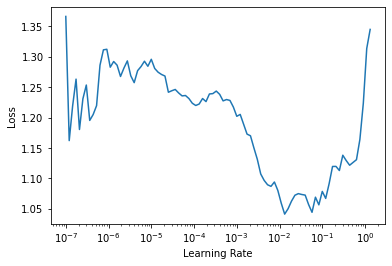

In [ ]:
vgg16_model.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.826608,0.554792,0.795455,00:57


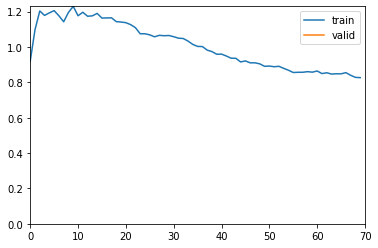

epoch,train_loss,valid_loss,accuracy,time
0,0.621304,0.516016,0.808081,00:25
1,0.603205,0.453258,0.815657,00:24
2,0.532857,0.410000,0.835859,00:24
3,0.483611,0.367676,0.845960,00:24
4,0.405532,0.340646,0.851010,00:24
5,0.365141,0.329409,0.866162,00:24
6,0.338972,0.326708,0.871212,00:24
7,0.325766,0.300054,0.868687,00:24
8,0.300051,0.301425,0.866162,00:24
9,0.271311,0.291925,0.876263,00:24


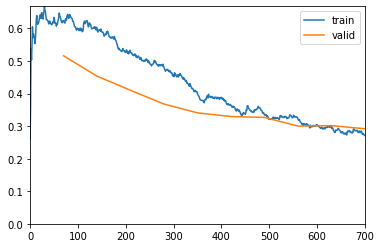

In [ ]:
vgg16_model.fine_tune(10, 2e-3)

In [ ]:
vgg16_model.save('VGG16_128_01')

Path('/content/drive/My Drive/Dataset/models/VGG16_128_01.pth')

## Progressive Resizing

In [ ]:
vgg16_model = None
data = None
torch.cuda.empty_cache()

In [ ]:
data = get_data(224, 32)  

In [ ]:
vgg16_model = cnn_learner(data, vgg16_bn, opt_func=ranger, cbs=[ShowGraphCallback], model_dir=model_path, metrics = [accuracy]).to_fp16()
vgg16_model.load('VGG16_128_01')
vgg16_model.freeze()

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=5.754399353463669e-07, lr_steep=7.585775847473997e-07)

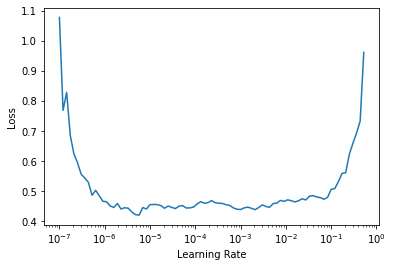

In [ ]:
vgg16_model.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.356134,0.283170,0.868687,00:30


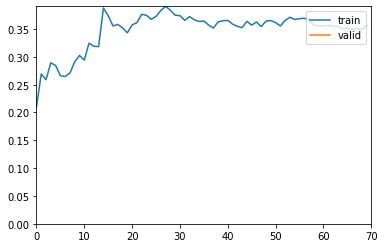

epoch,train_loss,valid_loss,accuracy,time
0,0.334358,0.264476,0.878788,00:32
1,0.341416,0.254216,0.871212,00:31
2,0.307310,0.235337,0.883838,00:31
3,0.286793,0.246141,0.886364,00:31
4,0.264805,0.244199,0.873737,00:31
5,0.231058,0.245561,0.891414,00:31
6,0.194696,0.236646,0.909091,00:31
7,0.189267,0.234476,0.891414,00:31
8,0.177058,0.239070,0.904040,00:31
9,0.167896,0.243734,0.898990,00:31


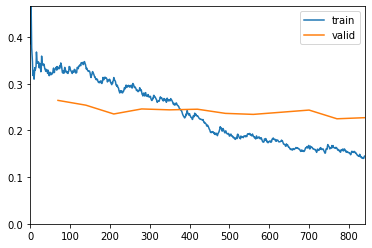

In [ ]:
vgg16_model.fine_tune(12, wd=0.01)

In [ ]:
vgg16_model.save('VGG16_224_01')

Path('/content/drive/My Drive/Dataset/models/VGG16_224_01.pth')

## Observer missclassified images

In [ ]:
vgg16_model.load('VGG16_224_01')

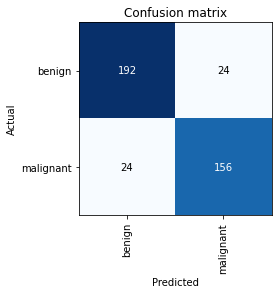

In [28]:
interp = ClassificationInterpretation.from_learner(vgg16_model.to_fp16())
interp.plot_confusion_matrix();

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

      benign       0.89      0.94      0.92       216
   malignant       0.93      0.86      0.89       180

    accuracy                           0.91       396
   macro avg       0.91      0.90      0.91       396
weighted avg       0.91      0.91      0.91       396



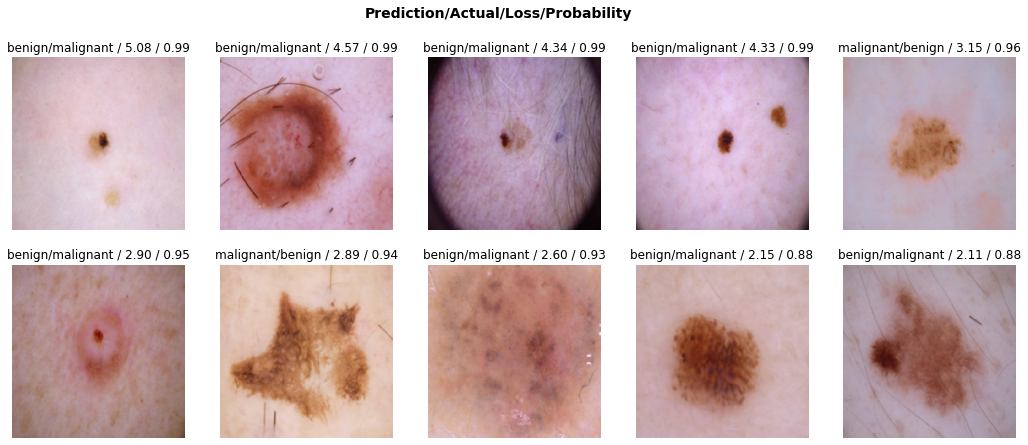

In [ ]:
interp.plot_top_losses(10, nrows=2, ncols=5, figsize=(18,7))

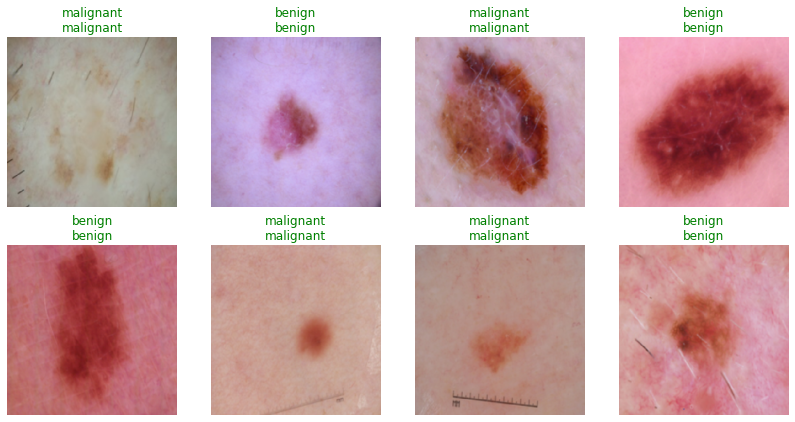

In [ ]:
vgg16_model.show_results(max_n=8, nrows=2, ncols=4, figsize=(14,7))

# Evaluation on Testing data

In [29]:
data = get_data(224, 32)
vgg16_model = cnn_learner(data, vgg16_bn, opt_func=ranger, cbs=[ShowGraphCallback], 
                             model_dir=model_path, metrics = [accuracy]).to_fp16()
vgg16_model.load('VGG16_224_01')


In [30]:
test_path = Path(path/'test')
tst_fns = get_image_files(test_path)
# split label from Parent Folder
tst_lbl = [parent_label(fn) for fn in tst_fns]
dl = vgg16_model.dls.test_dl(tst_fns, with_labels=True)

tst_lbl_num = [0 if lbl == 'benign' else 1 for lbl in tst_lbl]
tst_lbl_num[:10], tst_lbl_num[-10:]

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

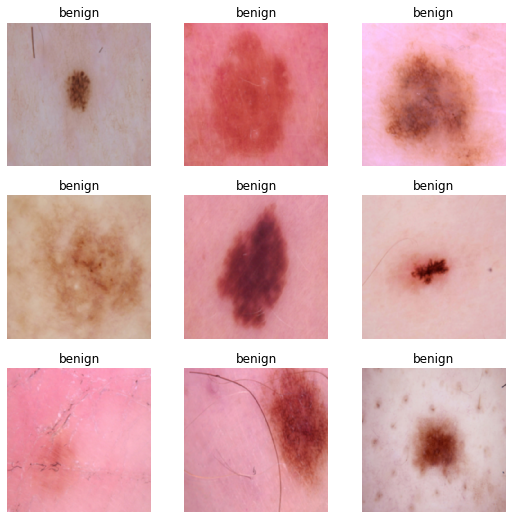

In [ ]:
dl.show_batch()

In [9]:
# Using Test Time Augmentation Technique
preds, _ = vgg16_model.tta(dl=dl)

In [31]:
# Normal Prediction (without augmentation on the testing set)
preds, _ = vgg16_model.get_preds(dl=dl)

In [32]:
preds_num = preds.argmax(1)
preds_num[:10], preds_num[-10:]

(TensorImage([1, 1, 1, 1, 1, 1, 1, 1, 0, 1]),
 TensorImage([0, 1, 0, 0, 0, 1, 0, 1, 0, 0]))

In [33]:
def plot_confusion_matrix(cm, classes):
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

In [34]:
accuracy_score(tst_lbl_num, preds_num)

0.8939393939393939

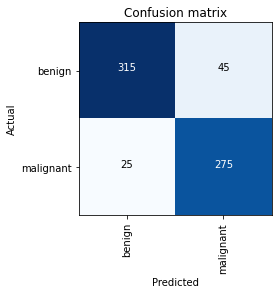

In [35]:
cm = confusion_matrix(tst_lbl_num, preds_num)
plot_confusion_matrix(cm, data.vocab)

In [36]:
print(classification_report(tst_lbl_num, preds_num))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       360
           1       0.86      0.92      0.89       300

    accuracy                           0.89       660
   macro avg       0.89      0.90      0.89       660
weighted avg       0.90      0.89      0.89       660



# Save Prediction

In [37]:
def get_model_prob_csv(model, dls, model_name):
  if dls == 'valid':
    val_path = Path(path/'valid')
    val_fns = get_image_files(val_path)
    val_lbl = [parent_label(fn) for fn in val_fns]
    Y_val = [0 if lbl == 'benign' else 1 for lbl in val_lbl]
    prob, _ = model.get_preds(dl=model.dls.valid)
    #Save Prediction in csv file
    df = pd.DataFrame({'val_prob': np.array(prob[:,1]), 
                       'pred_y': np.array(prob.argmax(1)),'y': Y_val})
    df.to_csv(path/"val_result_{}.csv".format(model_name), index=False)
    print('Validation dataframe created ...')

  elif dls == 'test':
    test_path = Path(path/'test')
    tst_fns = get_image_files(test_path)
    tst_lbl = [parent_label(fn) for fn in tst_fns]
    Y_test = [0 if lbl == 'benign' else 1 for lbl in tst_lbl]
    dl = model.dls.test_dl(tst_fns, with_labels=True)
    prob, _ = model.get_preds(dl=dl)
    #Save Prediction in csv file
    df = pd.DataFrame({'tet_prob': np.array(prob[:,1]), 
                       'pred_y': np.array(prob.argmax(1)), 'y': Y_test})
    df.to_csv(path/"test_result_{}.csv".format(model_name) , index=False)
    print('Test dataframe created ...')


In [38]:
get_model_prob_csv(model=vgg16_model, dls='valid', model_name='vgg16_notta')
get_model_prob_csv(model=vgg16_model, dls='test', model_name='vgg16_notta')

Validation dataframe created ...


Test dataframe created ...


In [39]:
## Download the csv files
valid_df = pd.read_csv(path/'val_result_vgg16_notta.csv')
test_df = pd.read_csv(path/'test_result_vgg16_notta.csv')

In [40]:
valid_df.head()

,val_prob,pred_y,y
0,0.999828,1,1
1,0.998033,1,1
2,0.289924,0,1
3,0.004896,0,1
4,0.895340,1,1


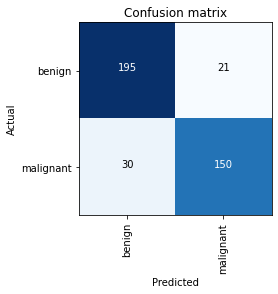

0.8712121212121212

In [41]:
cm = confusion_matrix(valid_df.y, valid_df.pred_y)
plot_confusion_matrix(cm, data.vocab)
accuracy_score(valid_df.y, valid_df.pred_y)

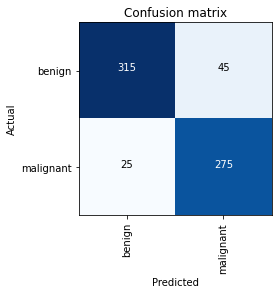

0.8939393939393939

In [42]:
cm = confusion_matrix(test_df.y, test_df.pred_y)
plot_confusion_matrix(cm, data.vocab)
accuracy_score(test_df.y, test_df.pred_y)

In [43]:
print(classification_report(test_df.y, test_df.pred_y))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       360
           1       0.86      0.92      0.89       300

    accuracy                           0.89       660
   macro avg       0.89      0.90      0.89       660
weighted avg       0.90      0.89      0.89       660



# Export Model

In [44]:
vgg16_model.export('vgg16.pkl') 
(path/'deployment').ls(file_exts='.pkl') # check if the saved model is in the path

(#9) [Path('/content/drive/My Drive/Dataset/deployment/EfficientNetB0.pkl'),Path('/content/drive/My Drive/Dataset/deployment/ResNet50.pkl'),Path('/content/drive/My Drive/Dataset/deployment/ResNext101.pkl'),Path('/content/drive/My Drive/Dataset/deployment/DenseNet169.pkl'),Path('/content/drive/My Drive/Dataset/deployment/squeezenet1_1.pkl'),Path('/content/drive/My Drive/Dataset/deployment/LinearSVC_ELT.pkl'),Path('/content/drive/My Drive/Dataset/deployment/logisticELT.pkl'),Path('/content/drive/My Drive/Dataset/deployment/vgg16.pkl'),Path('/content/drive/My Drive/Dataset/deployment/vgg16old.pkl')]